In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

**Data** **Preperation**

In [ ]:
dataset,dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
DATASET_SIZE = len(dataset)

dataset = tf.data.Dataset.range(10)

train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

# print(list(train_dataset.as_numpy_iterator()))
# dataset = tf.data.Dataset.range(10)
# dataset = dataset.skip(7)
# list(dataset.as_numpy_iterator())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
def split(dataset,train_dataset,val_dataset,test_dataset):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset,val_dataset,test_dataset

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
DATASET_SIZE = len(dataset[0])

train_dataset = dataset[0].take(int(TRAIN_RATIO * DATASET_SIZE))
val_test_dataset = dataset[0].skip(int(TRAIN_RATIO * DATASET_SIZE))
val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_dataset,val_dataset,test_dataset = split(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp0apobq10tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [ ]:
for data in dataset['train'].take(1):
  print(data)

{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


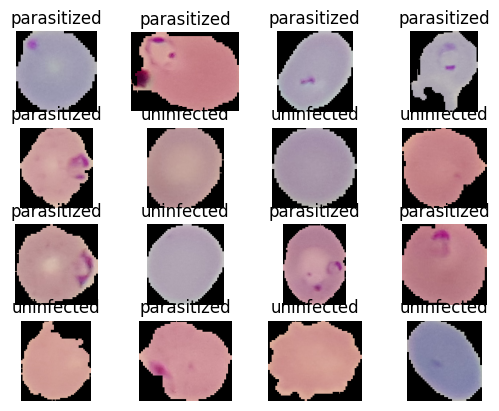

In [ ]:
for i ,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i + 1)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.imshow(image)
  plt.axis('off')

**Data Preprocessing**

In [ ]:
for image,label in train_dataset.take(1):
  print(image)
  print(label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
IM_SIZE = 224
def resizing_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_dataset)
print(test_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**Sequential api model**

In [ ]:
IM_SIZE = 224
model = tf.keras.Sequential([
        InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),

        Conv2D(filters = 6, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
        BatchNormalization(),
        MaxPool2D(pool_size = 2,strides = 2),

        Conv2D(filters = 16, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
        BatchNormalization(),
        MaxPool2D(pool_size = 2,strides = 2),

        Flatten(),

        Dense(100,activation = "relu"),
        BatchNormalization(),
        Dense(10,activation = "relu"),
        BatchNormalization(),
        Dense(1,activation = "sigmoid"),


])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.1), loss = BinaryCrossentropy(),metrics = 'accuracy')

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 10, verbose = 1)

Epoch 1/10
517/517 [==============================] - 76s 80ms/step - loss: 0.2668 - accuracy: 0.9134 - val_loss: 1.5027 - val_accuracy: 0.4758
Epoch 2/10
517/517 [==============================] - 42s 82ms/step - loss: 0.2503 - accuracy: 0.9203 - val_loss: 3.7223 - val_accuracy: 0.4972
Epoch 3/10
517/517 [==============================] - 46s 89ms/step - loss: 0.2624 - accuracy: 0.9162 - val_loss: 6.5473 - val_accuracy: 0.9173
Epoch 4/10
517/517 [==============================] - 41s 79ms/step - loss: 0.2169 - accuracy: 0.9348 - val_loss: 0.8089 - val_accuracy: 0.7576
Epoch 5/10
517/517 [==============================] - 46s 90ms/step - loss: 0.2112 - accuracy: 0.9359 - val_loss: 0.2386 - val_accuracy: 0.9350
Epoch 6/10
517/517 [==============================] - 41s 79ms/step - loss: 0.1869 - accuracy: 0.9425 - val_loss: 0.1941 - val_accuracy: 0.9392
Epoch 7/10
517/517 [==============================] - 40s 77ms/step - loss: 0.1702 - accuracy: 0.9472 - val_loss: 4.6823 - val_accuracy:

In [ ]:
for k,v in history.history.items():
  print(k)

loss
accuracy
val_loss
val_accuracy


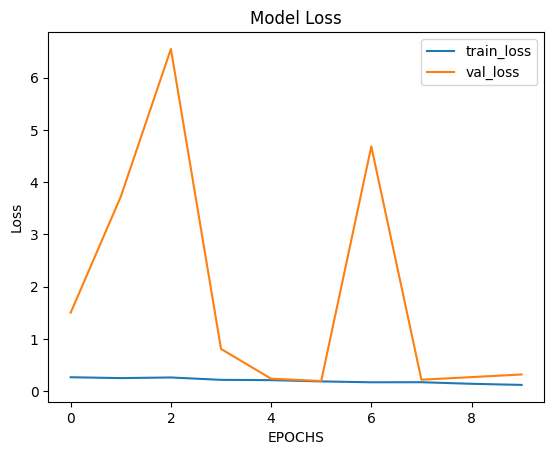

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("EPOCHS")
plt.legend(['train_loss','val_loss'])
plt.show()

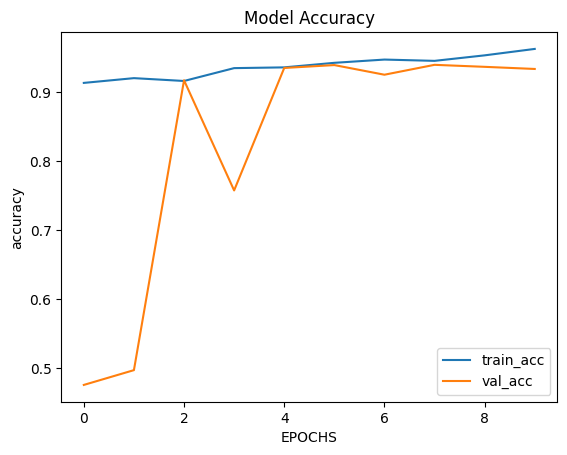

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("EPOCHS")
plt.legend(['train_acc','val_acc'])
plt.show()

**MODLE EVALUATE**

In [ ]:
model.evaluate(test_dataset)

173/173 [==============================] - 18s 45ms/step - loss: 0.2885 - accuracy: 0.9318


[0.28849807381629944, 0.9317975640296936]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 14s 14s/step


0.9999256

In [ ]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')


1/1 [==============================] - 0s 40ms/step


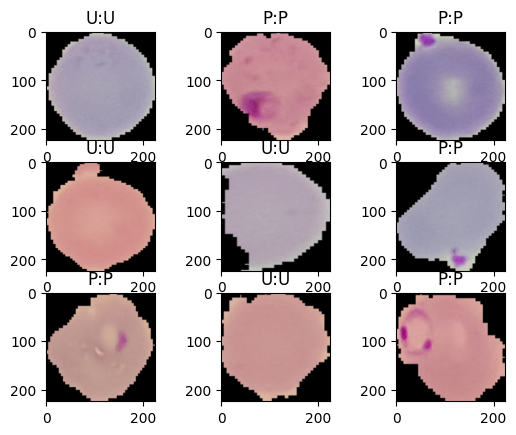

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3,i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))